Author: 
**Philipp Schwarz** <br>
Quantitative Modeler and Data Scientist<br>
Policy Analysis, Delft University of Technology<br>

<table id="btable" width='200' cellspacing='0' cellpadding='0' border-spacing='0' style="width:200px;margin:0;padding:0;">
  <tr>
    <td>
      <a href="https://de.linkedin.com/in/philippschwarztudelft" target="_blank" title="ProfilePic" style="border:none;text-decoration:none;">
        <img src="https://pbs.twimg.com/profile_images/776406575804186624/bDcqGK7W_400x400.jpg" alt="Profile_Image" style="border:none;width:80px;height:80px;">
      </a>
    </td>

    <td>
            <a href="https://twitter.com/philippschw_" target="_blank" title="Twitter" style="text-decoration:none;">
              <img src="https://www.webceo.com/blog/wp-content/uploads/2015/11/twitter.jpg" alt="Profile_Image" style="border:none;width:30px;height:30px;"></a>
    </td>


    
  </tr>
</table>

## Humanitarian Security Incidents
#### - Analysis across different dimensions: Spatial, temporal and type of attack- 

Raw data pulled from: 

* https://aidworkersecurity.org/incidents
* Incidents are derived from The Aid Worker Security Database (AWSD). 
* Database records major incidents of violence against aid workers
* Incident reports from 1997 through the present
* Last updated: August 16, 2016, Data verified up to: December 31, 2015

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Pull data in and add abbreviation

In [2]:
rawdatapath = 'raw_data/aidworkersecurity/'
dic_organization = pd.read_excel(rawdatapath+"Abbreviation.xlsx", sheetname="Key for organisation type", header=None )
dic_means_attack = pd.read_excel(rawdatapath+"Abbreviation.xlsx", sheetname="Key for means of attack", header=None )
dic_context_attack = pd.read_excel(rawdatapath+"Abbreviation.xlsx", sheetname="Key for attack context", header=None )
dic_location  = pd.read_excel(rawdatapath+"Abbreviation.xlsx", sheetname="Key for location", header=None )

In [3]:
dic_organization = dict(zip(dic_organization[0],dic_organization[1]))
dic_means_attack = dict(zip(dic_means_attack[0],dic_means_attack[1]))
dic_context_attack = dict(zip(dic_context_attack[0],dic_context_attack[1]))
dic_location = dict(zip(dic_location[0],dic_location[1]))

In [4]:
def f(x):
    if ' or ' in x:
        return x.split(' ')[0]
    elif '/' in x: 
        return x.split('/')[0]
    else:
        return x.split('(')[0]

In [5]:
dic_location =  {k: f(v) for k, v in dic_location.iteritems()}
dic_context_attack =  {k: f(v) for k, v in dic_context_attack.iteritems()}
dic_organization =  {k: f(v) for k, v in dic_organization.iteritems()}
dic_means_attack =  {k: f(v) for k, v in dic_means_attack.iteritems()}

In [6]:
df_incidents=pd.read_csv(rawdatapath+'security_incidents2016-10-03.csv')

In [7]:
df_incidents.columns

Index([u'Incident ID', u'Year', u'Month', u'Day', u'Country', u'Region',
       u'District', u'City', u'UN', u'INGO', u'LNGO/NRCS', u'ICRC', u'IFRC',
       u'Other', u'Nationals killed', u'Nationals wounded',
       u'Nationals kidnapped', u'Total nationals', u'Internationals killed',
       u'Internationals wounded', u'Internationals kidnapped',
       u'Total internationals', u'Total killed', u'Total wounded',
       u'Total kidnapped', u'Total affected', u'Gender Male', u'Gender Female',
       u'Gender Unknown', u'Means of attack', u'Attack context', u'Location',
       u'Latitude', u'Longitude', u'Details'],
      dtype='object')

In [8]:
df_incidents = df_incidents.replace({'Location': dic_location,
                             'Means of attack': dic_means_attack,
                            'Attack context': dic_context_attack})

In [9]:
from zipfile import ZipFile
import os

def get_shape_file(filename):

#     # download file
#     zipped = filename + '.zip'
#     urlretrieve('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile', zipped)
#     zipped = os.getcwd() + '/' + zipped

    # unzip file
    to_unzip = ZipFile(filename, 'r')
    unzipped = os.getcwd() + '/' + filename + '_unzipped'
    to_unzip.extractall(unzipped)
    to_unzip.close()

    # get shape file
    for file in os.listdir(unzipped):
        if file.endswith(".shp"):
            shape_file =  unzipped + '/' + file

    # return full file path
    return shape_file

In [10]:
import geopandas as gp
gdf = gp.GeoDataFrame.from_file(get_shape_file('raw_data/ne_50m_admin_0_countries.zip'))
df_incidents_geo = df_incidents[pd.notnull(df_incidents['Longitude'])]

df_incidents_geo['Latitude'] = df_incidents_geo['Latitude'].map(lambda x: x.rstrip(')'))
df_incidents_geo['Longitude'] = df_incidents_geo['Longitude'].map(lambda x: x.rstrip(')'))

df_incidents_geo['Latitude'] = df_incidents_geo['Latitude'].map(lambda x: x.split(",")[0])
df_incidents_geo['Longitude'] = df_incidents_geo['Longitude'].map(lambda x: x.split(",")[0])

df_incidents_geo['Longitude'] = df_incidents_geo['Longitude'].astype(float)
df_incidents_geo['Latitude'] = df_incidents_geo['Latitude'].astype(float)

 

In [11]:
# Create Shapely point from long and lat
import shapely
create_point = lambda x: shapely.geometry.Point(x['Longitude'], x['Latitude'])
df_incidents_geo['geometry'] = df_incidents_geo.apply(create_point, axis=1)

gdf_df_incidents =  gp.GeoDataFrame(df_incidents_geo, crs=gdf.crs)

In [12]:
# Perform spatial join
from geopandas.tools import sjoin
joined_gdf = sjoin(gdf_df_incidents, gdf, how="inner", op='intersects')

In [13]:
print joined_gdf.shape
print joined_gdf.columns

(1962, 100)
Index([             u'Incident ID',                     u'Year',
                          u'Month',                      u'Day',
                        u'Country',                   u'Region',
                       u'District',                     u'City',
                             u'UN',                     u'INGO',
                      u'LNGO/NRCS',                     u'ICRC',
                           u'IFRC',                    u'Other',
               u'Nationals killed',        u'Nationals wounded',
            u'Nationals kidnapped',          u'Total nationals',
          u'Internationals killed',   u'Internationals wounded',
       u'Internationals kidnapped',     u'Total internationals',
                   u'Total killed',            u'Total wounded',
                u'Total kidnapped',           u'Total affected',
                    u'Gender Male',            u'Gender Female',
                 u'Gender Unknown',          u'Means of attack',
             

In [14]:
row_ids = joined_gdf[joined_gdf['Country'] != joined_gdf['admin']].index
joined_gdf.ix[row_ids].set_index('admin').index.unique()

array([u'Tajikistan', u'Democratic Republic of the Congo', u'Russia',
       u'South Sudan', u'Ethiopia', u'Sudan', u'Somaliland', u'Pakistan',
       u'Palestine', u'Republic of Congo', u'Ivory Coast', u'Chad',
       u'United Republic of Tanzania', u'Algeria', u'Libya', u'Syria',
       u'Turkey', u'Israel'], dtype=object)

In [15]:
joined_gdf.ix[row_ids].set_index('admin').ix['Russia']

,Incident ID,Year,Month,Day,Country,Region,District,City,UN,INGO,...,su_dif,subregion,subunit,tiny,type,un_a3,wb_a2,wb_a3,wikipedia,woe_id
admin,,,,,,,,,,,,,,,,,,,,,
Russia,18,1997,7.0,NaN,Chechnya,NaN,Nazranovsky,Nazran,0,1,...,0.0,Eastern Europe,Russia,-99.0,Sovereign country,643,RU,RUS,-99.0,-99.0
Russia,17,1997,7.0,NaN,Chechnya,NaN,NaN,NaN,0,2,...,0.0,Eastern Europe,Russia,-99.0,Sovereign country,643,RU,RUS,-99.0,-99.0
Russia,16,1997,7.0,NaN,Chechnya,NaN,NaN,NaN,0,1,...,0.0,Eastern Europe,Russia,-99.0,Sovereign country,643,RU,RUS,-99.0,-99.0
Russia,21,1997,8.0,NaN,Chechnya,Dagestan,NaN,NaN,0,4,...,0.0,Eastern Europe,Russia,-99.0,Sovereign country,643,RU,RUS,-99.0,-99.0
Russia,29,1997,10.0,23.0,Chechnya,NaN,NaN,Grozny,0,2,...,0.0,Eastern Europe,Russia,-99.0,Sovereign country,643,RU,RUS,-99.0,-99.0
Russia,33,1997,12.0,17.0,Chechnya,NaN,NaN,NaN,0,5,...,0.0,Eastern Europe,Russia,-99.0,Sovereign country,643,RU,RUS,-99.0,-99.0
Russia,36,1998,1.0,29.0,Chechnya,North Ossetia,NaN,NaN,2,0,...,0.0,Eastern Europe,Russia,-99.0,Sovereign country,643,RU,RUS,-99.0,-99.0
Russia,75,1999,5.0,15.0,Chechnya,Kabardino-Balkaria,NaN,NaN,0,0,...,0.0,Eastern Europe,Russia,-99.0,Sovereign country,643,RU,RUS,-99.0,-99.0
Russia,88,1999,10.0,NaN,Chechnya,NaN,NaN,NaN,0,0,...,0.0,Eastern Europe,Russia,-99.0,Sovereign country,643,RU,RUS,-99.0,-99.0


#### Transform individual columns Year, Month, and Day into single datetime and save it

In [16]:
import datetime
df_incidents_datetime = df_incidents[df_incidents.Day.notnull()]
df_incidents_datetime[['Year', 'Month', 'Day']] = df_incidents_datetime[['Year', 'Month', 'Day']].astype(int)
df_incidents_datetime['DateTime'] = df_incidents_datetime[['Year', 'Month', 'Day']].apply(lambda s : datetime.datetime(*s),axis = 1)
print df_incidents_datetime['DateTime'].head()
df_incidents_datetime.to_csv('processed_data/security_incidents2016-10-03_datetime.csv')


5    1997-02-14
7    1997-05-07
9    1997-06-08
10   1997-06-14
11   1997-06-17
Name: DateTime, dtype: datetime64[ns]


#### Lets have a first look at the data base structure

In [17]:
print df_incidents.shape
print df_incidents.columns
df_incidents.head(2)

(2088, 35)
Index([u'Incident ID', u'Year', u'Month', u'Day', u'Country', u'Region',
       u'District', u'City', u'UN', u'INGO', u'LNGO/NRCS', u'ICRC', u'IFRC',
       u'Other', u'Nationals killed', u'Nationals wounded',
       u'Nationals kidnapped', u'Total nationals', u'Internationals killed',
       u'Internationals wounded', u'Internationals kidnapped',
       u'Total internationals', u'Total killed', u'Total wounded',
       u'Total kidnapped', u'Total affected', u'Gender Male', u'Gender Female',
       u'Gender Unknown', u'Means of attack', u'Attack context', u'Location',
       u'Latitude', u'Longitude', u'Details'],
      dtype='object')


,Incident ID,Year,Month,Day,Country,Region,District,City,UN,INGO,...,Total affected,Gender Male,Gender Female,Gender Unknown,Means of attack,Attack context,Location,Latitude,Longitude,Details
0,35,1997,NaN,NaN,NaN,NaN,NaN,NaN,0,0,...,2,0,0,2,Unknown,Unknown,Unknown,NaN,NaN,1 ICRC international staff wounded and 1 natl ...
1,2,1997,1.0,NaN,Rwanda,Northern,Musanze,Ruhengeri,0,4,...,4,3,1,0,Shooting (small arms,Raid,Office,-1.49984,29.63497,"3 INGO international (Spanish) staff killed, 1..."


It provides > 2000 records with spatial and temporal information: 

In [50]:
def savefigure(path):
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig('results/'+path, dpi=600)

## 1. Initial basic data exploration 

In [18]:
print df_incidents[df_incidents.Year == 2015]['Total killed'].sum()
print df_incidents[df_incidents.Year == 2015]['Total wounded'].sum()
print df_incidents[df_incidents.Year == 2015]['Total kidnapped'].sum()

109
110
68


#### Conclusion:
* In 2015, 287 aid workers were victims of major attacks. 109 killed - 110 wounded - 68 kidnapped

#### Trend Analysis

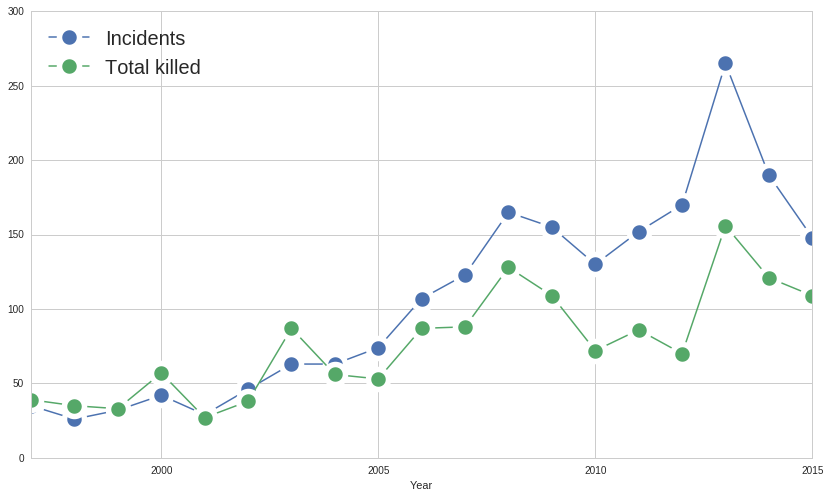

In [19]:
mpl.rcParams['figure.figsize'] = (14.0, 8.0)
df_incidents[(df_incidents.Year > 1995) & (df_incidents.Year < 2016)].rename(columns={'Incident ID': "Incidents"}).groupby('Year')[['Incidents',
                                                        'Total killed']].agg({'Incidents': {'Incidents': 'count'},
                                                                              'Total killed': {'Total killed': 'sum'}
                                                                             }).plot(kind='line', style='o-', mec='white',
                                                                                     ms=20,mew=5.5, linewidth=1.5, 
                                                                                    )
plt.legend(loc='upper left',scatterpoints=1,prop={'size':20});

In [20]:
df_incidents[(df_incidents.Year > 1995) & (df_incidents.Year < 2016)].rename(columns={'Incident ID': "Incidents"}).groupby('Year')[['Incidents',
                                                        'Total killed']].agg({'Incidents': {'Incidents': 'count'},
                                                                              'Total killed': {'Total killed': 'sum'}
                                                                             }).pct_change(axis=0).ix[2015]

Incidents      -0.221053
Total killed   -0.099174
Name: 2015, dtype: float64

#### Conclusion:
* Over the last fifteen years incidents (major attacks on aid workers) have increasinly lead to the death. On the positive side, 2015 was the second consecutive year with significanyly fewer incidents and causalities compared to the year before.
Compared to last year the number of incidents decreased by 22 % and causalities dropped by neaerly 10%

In [21]:
from pprintpp import pprint as pp
def plotdat(l, title_text='', sortON=True, plot_type="bar"):
    if sortON == True:
        l.sort_values(inplace=True)
    fig=plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    
    
    if plot_type=="line":
        l.plot(kind=plot_type, fontsize=12,color='k', marker='o', linestyle='dashed')
    else:
        l.plot(kind=plot_type, fontsize=12,color='k')

    
    plt.xlabel('')
    plt.ylabel('Number of incidents',fontsize=10)
    plt.title(title_text, fontsize=20)


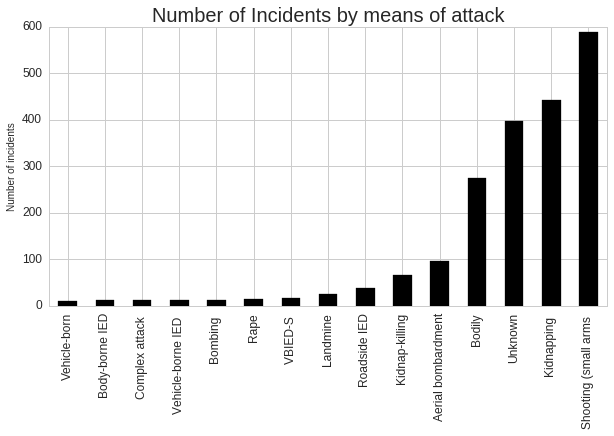

In [54]:
data, cat, title_text = df_incidents,'Means of attack', 'Number of Incidents by means of attack'
l=data.groupby(cat).size()
plotdat(l, title_text)
plt.show()
# pp(dict(dic_means_attack.items()))
 

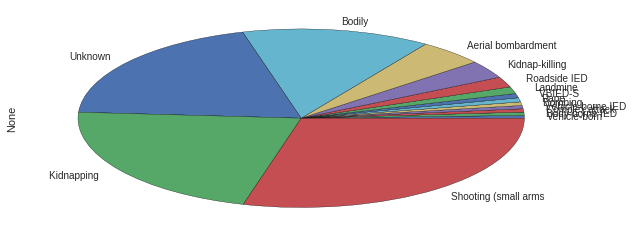

In [53]:
l.plot.pie();

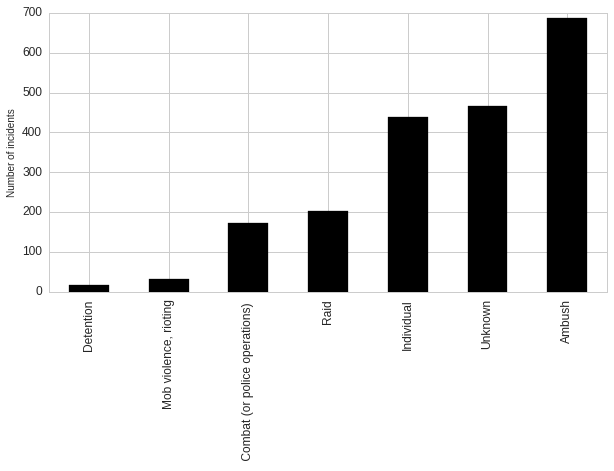

{
    u'Am': u'Ambush',
    u'C': u' Combat (or police operations) ',
    u'D': u'Detention',
    u'IA': u'Individual',
    u'MV': u'Mob violence, rioting',
    u'R': u'Raid',
    u'U': u'Unknown',
}


In [56]:
data, cat = df_incidents,'Attack context'
l=data.groupby(cat).size()
plotdat(l)
plt.show()
pp(dict(dic_context_attack.items()))

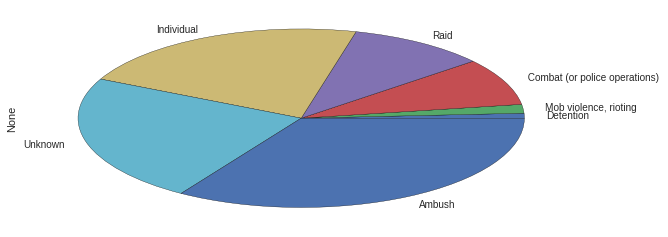

In [58]:
l.plot.pie();

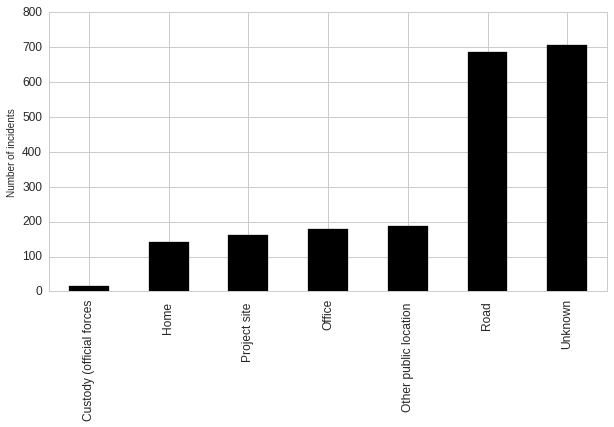

{
    u'C': u'Custody (official forces',
    u'H': u'Home ',
    u'OC': u'Office',
    u'P': u'Other public location ',
    u'PS': u'Project site ',
    u'R': u'Road ',
    u'U': u'Unknown',
}


In [24]:
data, cat = df_incidents,'Location'
l=data.groupby(cat).size()
plotdat(l)
plt.show()
pp(dict(dic_location.items()))

In [25]:
def cluster_2_column(df_incidents,per, x, y):
    
    # Group by crime type and district 
    hoods_per_type=df_incidents.groupby(y)[x].value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)
    
    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort_values(inplace=True, ascending=False)
    t=t[hood_sum.index]
    
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort_values(inplace=True)
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]
    return t
    
# t=cluster_2_column(df_incidents,0, )

In [26]:
t=cluster_2_column(df_incidents,0, x='Location', y= 'Means of attack')

Cluster the non-normalized data across the top percentile reports and each `PdDistrict`.

Normalize verically across `PdDistrict`.

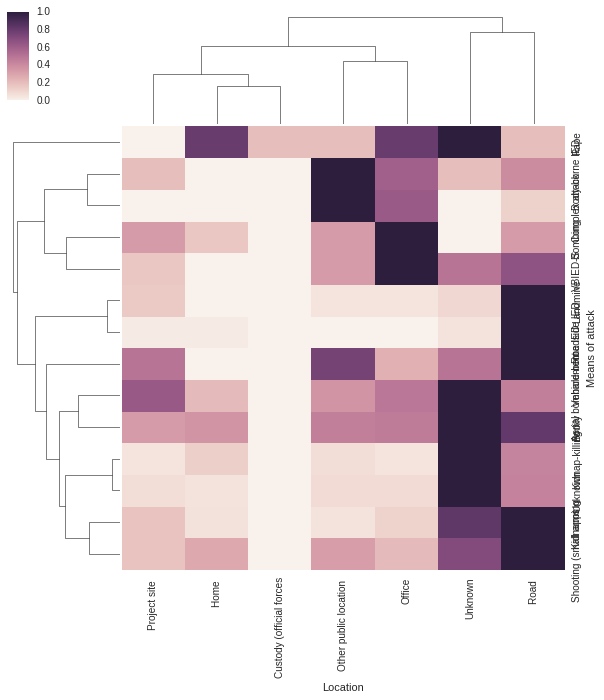

In [27]:
sns.clustermap(t,standard_scale=0);

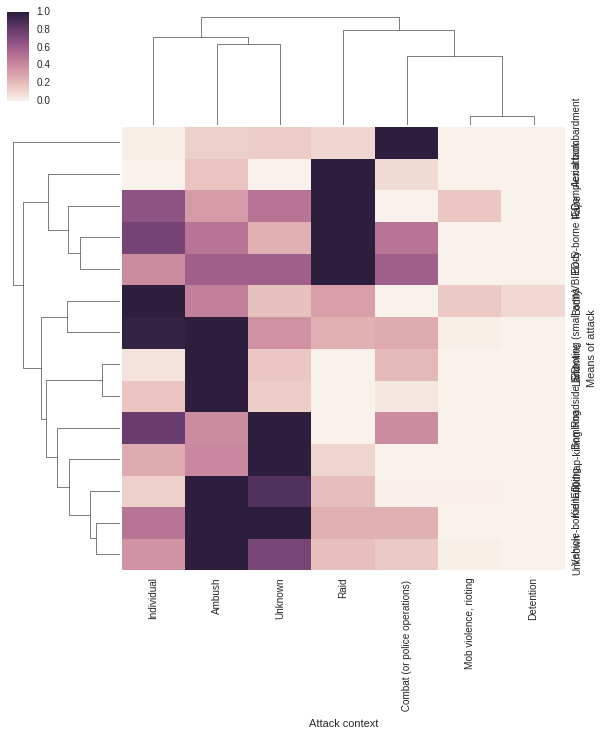

In [28]:
t=cluster_2_column(df_incidents,0, x='Attack context', y= 'Means of attack')
sns.clustermap(t,standard_scale=0);

#### Conclusions

(1) Ambush attack on roads are the most common attack context.

(2) The most common form of attack are:

* Shooting (small arms / light weapons, e.g. pistols, rifles, machine guns)',
* Kidnapping (not killed)',
* Bodily assault/beating/stabbing with non-fire weapons or no weapons',
* or Unknown

## 2. Temporal Analysis

Data is verified only up to: December 31, 2015, hence filter out the incidents in 2016 to avoid bias in temporal analysis

In [29]:
df_incidents = df_incidents[df_incidents.Year <= 2015]

#### General trend analysis

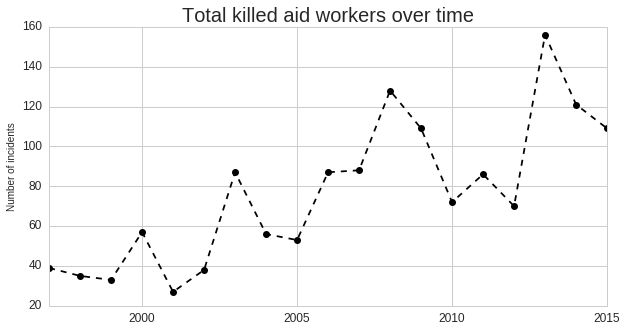

In [30]:
l=df_incidents.groupby('Year')['Total killed'].sum()
plotdat(l, sortON = False, title_text ="Total killed aid workers over time", plot_type='line' )

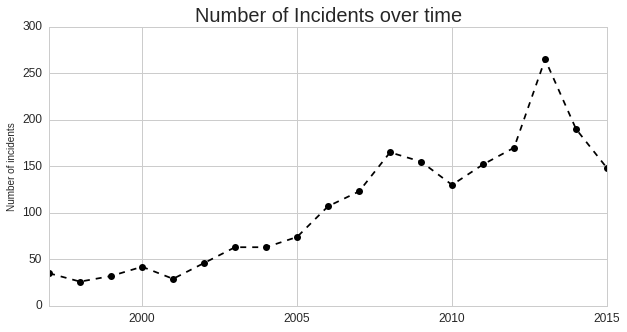

In [31]:
l=df_incidents.groupby('Year').size()
plotdat(l, sortON = False, title_text ="Number of Incidents over time",  plot_type='line')

In [61]:
l=df_incidents.groupby('Year').sum()

In [66]:
mpl.rcParams['figure.figsize'] = (12.0, 6.0)

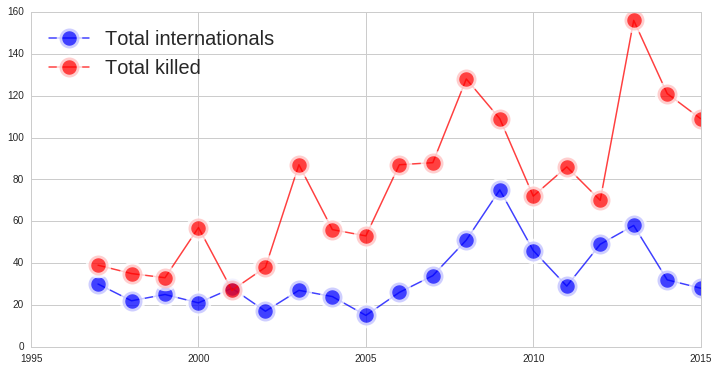

In [67]:
sns.set_context()
for d,c in zip(['Total internationals','Total killed'],['b','r']):
    plt.plot(l.index,l[d],'o-',color=c,ms=20,mew=5.5,mec='white',linewidth=1.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':20})
savefigure('Affected_nationals_vs_internations.png')

#### Trend analysis by category: (1) attack context, (2) means of attack, (3) location when attacked

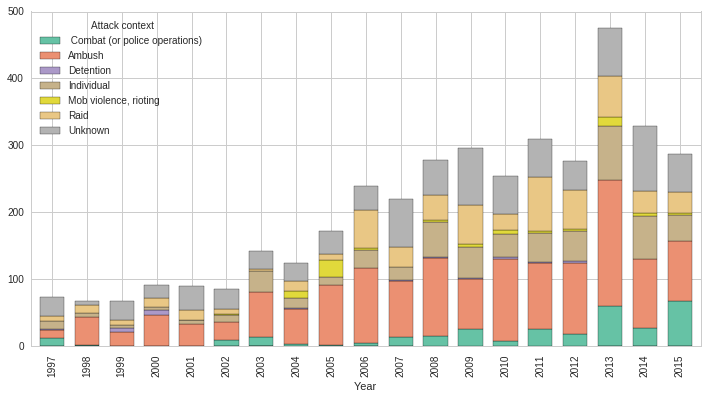

In [72]:
cat_per_time=df_incidents.groupby(['Year', 'Attack context'])['Total affected'].sum()
cat_per_time.unstack(level=1).plot(kind='bar', stacked=True,width=.7, fontsize=10, colormap='Set2');

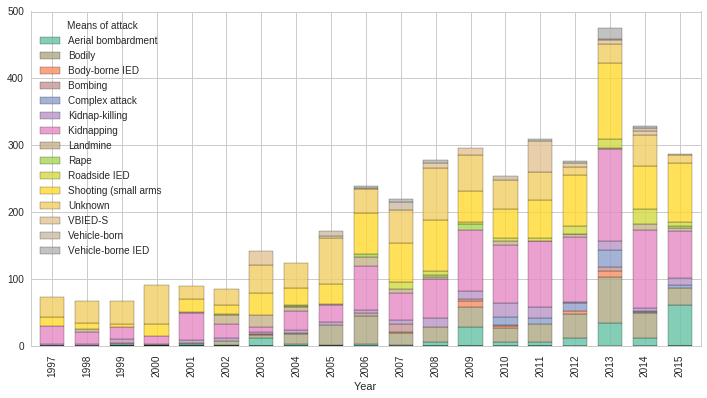

In [73]:
cat_per_time=df_incidents.groupby(['Year', 'Means of attack'])['Total affected'].sum()
cat_per_time.unstack(level=1).plot(kind='bar', stacked=True,width=.7, fontsize=10, colormap='Set2', alpha=.8);

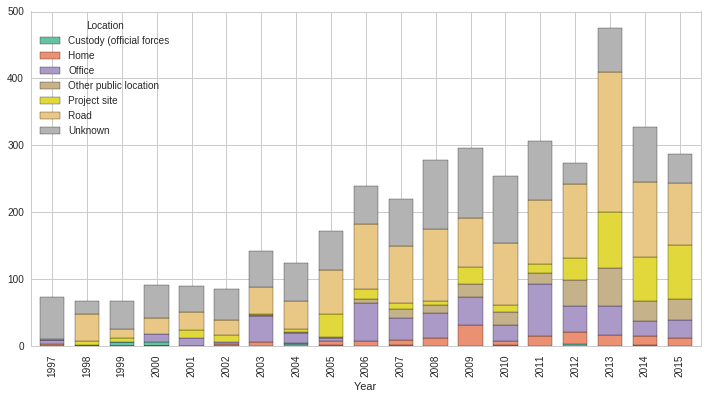

In [74]:
cat_per_time=df_incidents.groupby(['Year', 'Location'])['Total affected'].sum()
cat_per_time.unstack(level=1).plot(kind='bar', stacked=True,width=.7, fontsize=10, colormap='Set2', alpha=1)
savefigure('Location_Incident_temporal.png');

* Since 2013 the attacks on humanitarians at their Project site (village, camp, distribution point, hospital, etc.) has skyrocket


#### Exploration who is being affected?

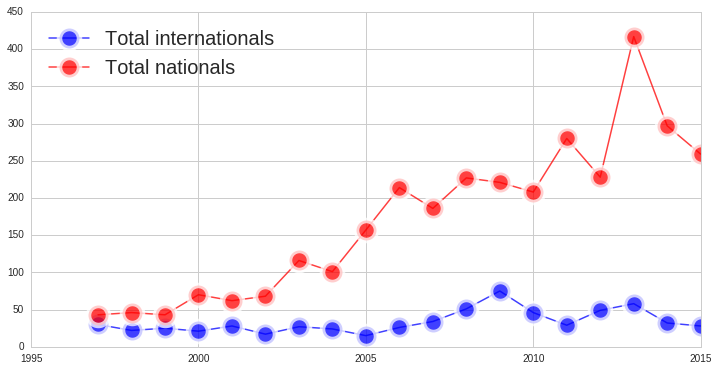

In [75]:
sns.set_context()
for d,c in zip(['Total internationals','Total nationals'],['b','r']):
    plt.plot(l.index,l[d],'o-',color=c,ms=20,mew=5.5,mec='white',linewidth=1.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':20})
savefigure('Affected_nationals_vs_internations.png')

* Over the last fifteen years the Number of serious incidents has continously increased, the increase of attacks has primarily affected national humanitarian aid workers!


#### WHO is targeted UN, Women? 

In addition, he found
more fatalities among NGOs (59 percent) than the UN (41 percent) and among local staff
(74 percent) than international staff (26 percent). 

#### Institutional affiliations of victims


In [ ]:
mpl.rcParams['figure.figsize'] = (14.0, 6.5)

df_incidents['ICRC/IFRC'] = df_incidents['ICRC'] + df_incidents['IFRC']

fs = df_incidents[['UN', 'INGO', 'LNGO/NRCS', 'ICRC/IFRC', 'Other']].sum()

from matplotlib import cm
cs=cm.coolwarm(np.arange(50)/3.3)
_, _, autotexts = plt.pie(fs,labels = fs.index,  autopct='%1.0f%%',pctdistance=0.9,startangle=90, colors=cs)
for autotext in autotexts:
    autotext.set_fontsize(18)
    autotext.set_color('w')
plt.axis("equal");

In [ ]:
mpl.rcParams['figure.figsize'] = (14.0, 6.5)

df_incidents['ICRC/IFRC'] = df_incidents['ICRC'] + df_incidents['IFRC']

fs = df_incidents[['UN', 'INGO', 'LNGO/NRCS', 'ICRC/IFRC', 'Other', 'Year']].groupby('Year').sum()


#### Trends in incident rates by institutions

In [ ]:
fs.tail(7).plot.bar(width=1.01, fontsize=10);

#### Conclusion
* Data set does not record affecting local NGOs!! -> The number of loca aid workers maybe largely underestimated

* Staff members of INGOs constitute the largest share of the victims of violent incidents in absolute terms, at around 50%. Personnel of UN aid agencies represent the second-largest portion (23%), followed by National Red Cross workers and local NGO at 24%. International (Federation and Committee) Red Cross and Red Crescent Societies contribute 4% and the final 1% is made up of personnel attached to other entities.

#### Exploration on the consequences of critical incident?

In [ ]:
for d,c in zip(['Total affected','Total kidnapped', 'Total wounded', 'Total killed'],['k','r', 'g', 'b']):
    plt.plot(l.index,l[d],'o-',color=c,ms=6,mew=1,mec='white',linewidth=0.5,label=d,alpha=0.75)
plt.legend(loc='upper left',scatterpoints=1,prop={'size':15})
savefigure('Incident_Consequence.png')

#### Conclusion

* There is not seperate trend towards more kidnapping, more deatly incident.

## 3. Spatial Analysis

In [ ]:
l = df_incidents.groupby('Country').size()
l = l[l>10] # More than 10 incidents 
plotdat(l, title_text='', sortON=True, plot_type="bar")

In [ ]:
import powerlaw 
fit = powerlaw.Fit(l)

print fit.xmin
print fit.alpha
print fit.power_law._pdf_discrete_normalizer
print fit.distribution_compare('power_law', 'lognormal')

In [ ]:
top5 = l.sort_values(ascending=False).ix[:5].copy()
top5=top5.reset_index()
frest = pd.DataFrame([["all other regions", l.sum()-top5[0].sum()]],columns=['Country', 0])
fs = pd.concat([top5,frest])

In [ ]:
from matplotlib import cm
cs=cm.coolwarm(np.arange(50)/5.)
_, _, autotexts = plt.pie(fs[0], labels = fs['Country'],autopct='%1.1f%%',pctdistance=0.8,startangle=180, colors=cs)
for autotext in autotexts:
    autotext.set_fontsize(17)
    autotext.set_color('w')
plt.axis("equal");

#### Conclusion: 
Risks to humanitarian aid workers are power law distributed. A small number of insecure locations (Afghanistan, Sudan, Somalia, Syria and Pakistan) account for most of the incidents.

#### Types of violence (2015) in the most dangerous regions

In [ ]:

state_office = df_incidents[(df_incidents['Country'].isin(fs['Country'][:5].tolist()))&(df_incidents['Year'] == 2015)].groupby(['Country', 'Means of attack']).count()

In [ ]:
state = df_incidents[(df_incidents['Country'].isin(fs['Country'][:5].tolist()))&(df_incidents['Year'] == 2015)].groupby(['Country']).count()
df = state_office.div(state, level='Country')['Attack context']

In [ ]:
ax = df.unstack('Means of attack').plot(kind='barh', stacked=True, colormap='gist_earth')
ax.legend(loc="upper left", bbox_to_anchor=(1,1));

#### Conclusion
* The types of violence directed at aid workers is dependent on the regional contexts. Looking into data from 2015 shows that in Afghanistan kidnapping is the prevalent mean of attack. However, in Sudan and Somalia, in contrast, shootings and (sexual) assualt are the most signifiant type of violence. Incidents caused by explosives and heavy weapons are with more than 50% only the majority of events in Syria. 



In [ ]:
len(df_incidents[df_incidents['Country']== 'Afghanistan'])

In [ ]:
from IPython.display import HTML
HTML('<iframe width="100%" height="520" frameborder="0" src="https://philippschw.carto.com/viz/da5caf7f-8ef3-47f2-aba9-8f5b7397a28a/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

#### NOTE: Data is slightly inconsistent, location does not always match with indicated nation

In [ ]:

HTML('<iframe width="100%" height="520" frameborder="0" src="https://philippschw.carto.com/viz/3dbcbef9-e81e-4180-a56b-e57729a3d59e/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

In [ ]:
HTML('<iframe width="100%" height="520" frameborder="0" src="https://philippschw.carto.com/viz/82b5fcb0-8a89-11e6-8881-0e8c56e2ffdb/embed_map" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

####  Challenge to How to measure relative risk
* Studies have recognized research gap that number of aid absolute aid workers is a crucial component that is missing (Sheik 2000 and Van Brabant 2000) 

* Data on number of aid workers in the field is not available

* The report 'Providing Aid in Insecure Environments: Trends in Policy and Operations' provides one of the first formal attempt to calculate an incidence rate for violence against aid workers by comparing global incident data against the estimated number of aid workers in the field (Stoddard et al. 2006)

#### Data on non violent threats to aid workers